## BMENE4460 Final Project
### Eugénie Dulout & Antoine Andurao

**ResNet18 with 1 slice**

This notebook contains our first experiements with ResNet18.

In this file, the input to each model was a [3, 224, 224] Tensor, each channel being a the same coronal slice from the same MRI (the same image is stacked 3 times because the model was pretrained on color images).

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
import os
import shutil
import nibabel as nib
import numpy as np
from glob import glob
from PIL import Image
from skimage import exposure
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

import time
from tempfile import TemporaryDirectory

In [15]:
# Define dataset directories
main_path = "/content/drive/MyDrive/BMENE4460/Final Project"

# Function to create new directories if they don't exist
def create_directories(dir_paths):
    for dir_path in dir_paths:
      if not os.path.exists(dir_path):
          os.makedirs(dir_path)

# Function to save slices for each patient
def save_slices(input_path, output_path, mode, diags, slices_index):

    for diag in diags:

      # Get file paths for each patient
      patient_paths = sorted(glob(os.path.join(input_path, f"{mode}/T1_affine/{diag}/*.nii.gz")))

      for patient_path in tqdm(patient_paths, total=len(patient_paths), desc=f"Loading patients and extracting slices for {mode} and {diag}"):

          # Extract patient ID from the file path
          patient_id = os.path.basename(patient_path)[:-7] # Removing the .nii.gz extension

          # Load the volume
          volume = nib.load(patient_path).get_fdata().astype(np.float32)

          # Normalization
          volume = 255*(volume / volume.max())

          # Save slices for each plane
          for plane, slice_index in slices_index.items():
              # In case the output directory doesn't exist yet
              os.makedirs(os.path.join(output_path, plane, mode, diag), exist_ok=True)

              if plane == 'axial':
                  slice_volume = volume[:, :, slice_index]
              elif plane == 'coronal':
                  slice_volume = volume[:, slice_index, :]
              elif plane == 'sagittal':
                  slice_volume = volume[slice_index, :, :]
              else:
                  raise ValueError(f"Invalid plane: {plane}")

              # Save the slice
              output_filename = f"{patient_id}_{slice_index}.png"
              output_filepath = os.path.join(output_path, plane, mode, diag, output_filename)
              (Image.fromarray(slice_volume).convert("L")).save(output_filepath)

# Define slices index
slices_index = {'axial': 100, 'coronal': 100, 'sagittal': 75}

output_path = main_path + '/data_ADNI'
input_path = main_path + '/ADNI_large_sample'
diags= {'AD', 'CN'}
# Save slices for train, validation, and test sets
save_slices(input_path, output_path, "train", diags, slices_index)
save_slices(input_path, output_path, "validation", diags, slices_index)
save_slices(input_path, output_path, "test", diags, slices_index)

Loading patients and extracting slices for validation and AD: 100%|██████████| 127/127 [01:52<00:00,  1.13it/s]
Loading patients and extracting slices for validation and CN: 100%|██████████| 126/126 [02:47<00:00,  1.33s/it]
Loading patients and extracting slices for test and AD: 100%|██████████| 131/131 [02:53<00:00,  1.32s/it]
Loading patients and extracting slices for test and CN: 100%|██████████| 129/129 [02:24<00:00,  1.12s/it]


In [74]:
# Set random seed for reproducibility
np.random.seed(4460)
torch.manual_seed(4460)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

class CLAHE():
    def __init__(self, clip_limit=0.02, tile_grid_size=(8, 8)):
        """
        Initialize CLAHE parameters.
        :param clip_limit: Threshold for contrast limiting.
        :param tile_grid_size: Size of the grid for the histogram equalization.
        """
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        """
        Apply CLAHE to a torch Tensor image.
        :param img: The input image torch Tensor.
        :return: Image after CLAHE as a torch Tensor.
        """
        # Ensure the image tensor is on CPU and convert it to numpy
        if isinstance(img, torch.Tensor):
            img = img.cpu()

        img_np = img.numpy()

        # Normalize the image data to [0, 1] for processing with skimage
        img_min = img_np.min()
        img_max = img_np.max()
        img_np = (img_np - img_min) / (img_max - img_min)

        # Apply CLAHE
        if img_np.ndim == 3:
            img_np = img_np[0]  # Remove channel dimension for processing

        clahe = exposure.equalize_adapthist(
            img_np,
            clip_limit=self.clip_limit,
            nbins=256,
            kernel_size=self.tile_grid_size
        )

        # Rescale back to the original range
        clahe = clahe * (img_max - img_min) + img_min

        # Convert back to a tensor
        clahe_tensor = torch.from_numpy(clahe).float()

        # Re-add the channel dimension if it was initially present
        if img.ndim == 3:
            clahe_tensor = clahe_tensor.unsqueeze(0)

        return clahe_tensor

class To3Channels:
    """Transform to duplicate 1-channel image to 3-channel image."""
    def __call__(self, x):
        return torch.cat([x, x, x], dim=0)

data_dir = "/content/drive/MyDrive/BMENE4460/Final Project/data_ADNI"
plane = "coronal"

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          CLAHE(),
          transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5)),
          To3Channels(),
    ]),
    'validation': transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          CLAHE(),
          transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5)),
          To3Channels(),
    ]),
    'test': transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          CLAHE(),
          transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5)),
          To3Channels(),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, plane, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([3, 224, 224])


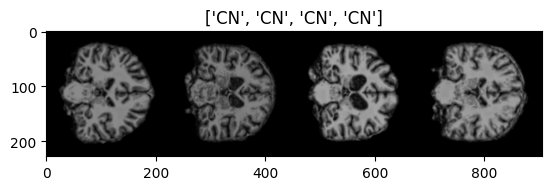

In [61]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(inputs[0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [62]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'validation']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [63]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns  # Ensure seaborn is installed for better visualization

def cm_and_acc(model, test_loader, device):

    # Evaluate the model
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    labels = sorted(list(set(true_labels)))  # Get sorted list of classes

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["CN", "AD"], yticklabels=["CN", "AD"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Display accuracy
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy * 100:.2f}%', ha='center', fontsize=12)
    plt.show()

    return accuracy

In [72]:
from sklearn.metrics import roc_auc_score, f1_score

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            # Assuming outputs are logits; apply sigmoid if needed
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(np.int32)  # Threshold the probabilities to obtain binary predictions

            y_scores.extend(probs[:, 1])  # Store probabilities for AUC calculation
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred, y_scores

In [64]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [65]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2018 Acc: 0.9389
validation Loss: 2.2190 Acc: 0.5020

Epoch 1/24
----------
train Loss: 0.0479 Acc: 0.9858
validation Loss: 2.7979 Acc: 0.5178

Epoch 2/24
----------
train Loss: 0.0290 Acc: 0.9929
validation Loss: 1.2330 Acc: 0.6601

Epoch 3/24
----------
train Loss: 0.0135 Acc: 0.9973
validation Loss: 2.6236 Acc: 0.5336

Epoch 4/24
----------
train Loss: 0.0023 Acc: 1.0000
validation Loss: 2.0160 Acc: 0.5889

Epoch 5/24
----------
train Loss: 0.0045 Acc: 0.9982
validation Loss: 2.8837 Acc: 0.5455

Epoch 6/24
----------
train Loss: 0.0109 Acc: 0.9973
validation Loss: 1.8599 Acc: 0.5731

Epoch 7/24
----------
train Loss: 0.0065 Acc: 0.9973
validation Loss: 1.7875 Acc: 0.5771

Epoch 8/24
----------
train Loss: 0.0024 Acc: 1.0000
validation Loss: 2.0457 Acc: 0.5731

Epoch 9/24
----------
train Loss: 0.0016 Acc: 1.0000
validation Loss: 1.7122 Acc: 0.5968

Epoch 10/24
----------
train Loss: 0.0019 Acc: 0.9991
validation Loss: 1.9823 Acc: 0.5731

Epoch 11/

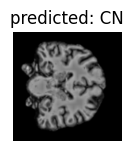

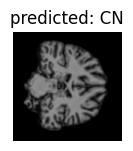

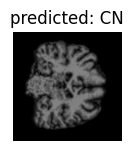

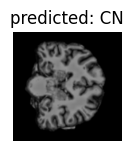

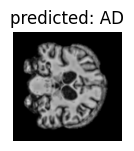

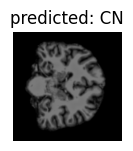

In [70]:
visualize_model(model_ft)

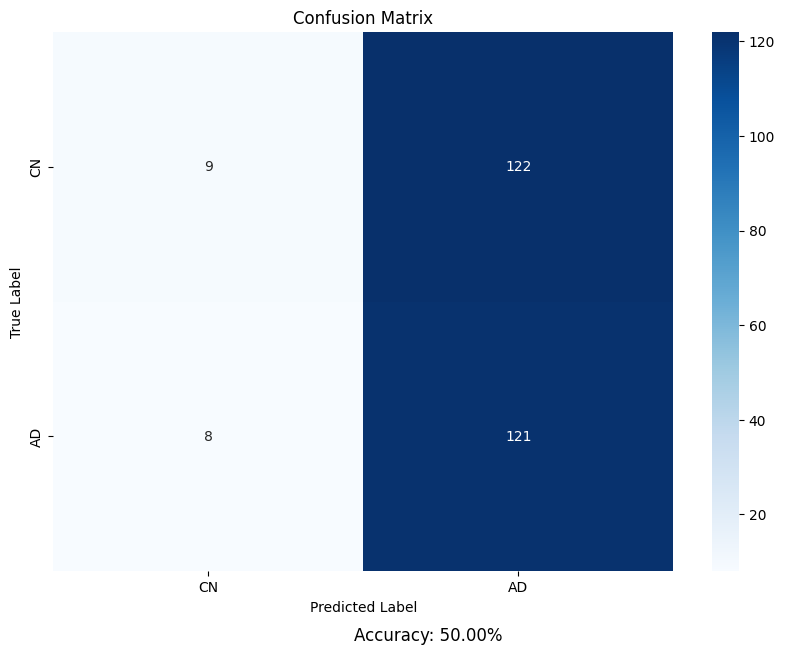

In [77]:
accuracy = cm_and_acc(model_ft, dataloaders['test'], device)

In [82]:
y_true, y_pred, y_scores = evaluate_model(model_ft, dataloaders['test'])

In [79]:
auc = roc_auc_score(y_true, y_scores)
f1 = f1_score(y_true, y_pred)

print(f'AUC: {auc}')
print(f'F1 Score: {f1}')

AUC: 0.6991537960826086
F1 Score: 0.6505376344086022


In [67]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [68]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3380 Acc: 0.9097
validation Loss: 0.9923 Acc: 0.4783

Epoch 1/24
----------
train Loss: 0.2607 Acc: 0.9159
validation Loss: 1.5145 Acc: 0.4822

Epoch 2/24
----------
train Loss: 0.2223 Acc: 0.9274
validation Loss: 2.4854 Acc: 0.4980

Epoch 3/24
----------
train Loss: 0.2647 Acc: 0.9097
validation Loss: 1.3825 Acc: 0.4862

Epoch 4/24
----------
train Loss: 0.2358 Acc: 0.9230
validation Loss: 2.4332 Acc: 0.4941

Epoch 5/24
----------
train Loss: 0.2319 Acc: 0.9177
validation Loss: 2.8441 Acc: 0.4941

Epoch 6/24
----------
train Loss: 0.1812 Acc: 0.9319
validation Loss: 1.5927 Acc: 0.4822

Epoch 7/24
----------
train Loss: 0.1540 Acc: 0.9442
validation Loss: 1.8690 Acc: 0.4704

Epoch 8/24
----------
train Loss: 0.1665 Acc: 0.9398
validation Loss: 1.6030 Acc: 0.4783

Epoch 9/24
----------
train Loss: 0.1452 Acc: 0.9496
validation Loss: 1.6001 Acc: 0.4783

Epoch 10/24
----------
train Loss: 0.1664 Acc: 0.9451
validation Loss: 1.5292 Acc: 0.4941

Epoch 11/

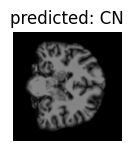

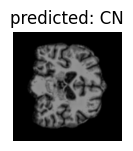

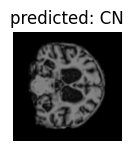

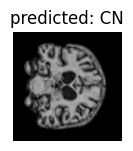

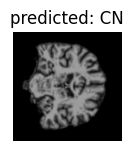

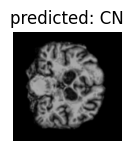

In [69]:
visualize_model(model_conv)

plt.ioff()
plt.show()

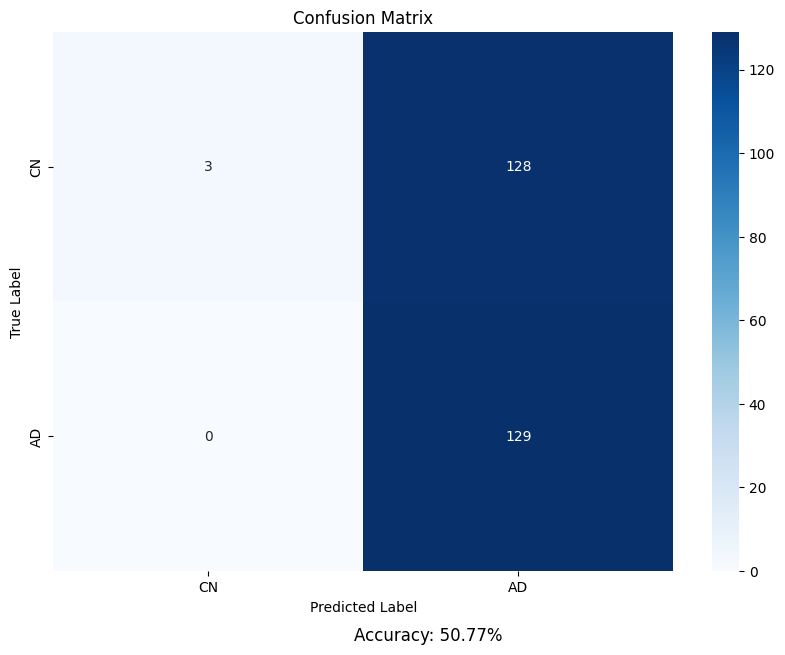

In [85]:
accuracy = cm_and_acc(model_conv, dataloaders['test'], device)

In [86]:
y_true, y_pred, y_scores = evaluate_model(model_ft, dataloaders['test'])

In [87]:
auc = roc_auc_score(y_true, y_scores)
f1 = f1_score(y_true, y_pred)

print(f'AUC: {auc}')
print(f'F1 Score: {f1}')

AUC: 0.6991537960826086
F1 Score: 0.6505376344086022
